In [1]:
import numpy as np
import torch
from torch import nn

import copy
import time
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
N_FRAMES = 4

In [3]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data, dtype="object")[indices]

        state_data = torch.tensor(np.stack(samples[:, 0])).float()
        act_data = torch.tensor(np.stack(samples[:, 1])).float()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).int()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

In [4]:
class DQN(nn.Module):
    def __init__(self, inp_size):
        
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(inp_size,64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(64,1))
            #nn.ReLU())
        
    def forward(self, state_action):
        q_value = self.layer1(state_action)
        q_value = self.layer2(q_value)
        q_value = self.layer3(q_value)
        
        return q_value
        
    def train_on_batch(self, target_model, optimizer, state0, act,
                                 reward, state1, terminal_data, acts, gamma=0.5):
        K=len(acts)
        
        inp = np.concatenate(([state1[0]]*K,acts),axis=1)

        if len(state1)>1:
            for i in state1[1:]:
                inp = np.concatenate((inp,np.concatenate(([i]*K,acts),axis=1)),axis=0)

       
        input = torch.tensor(inp).float() 
        

        q_values = self.forward(input)
        #print(q_values.reshape(-1,K))
        max_q_val = torch.max(q_values.reshape(-1,K),dim=1)[0].detach()
        
        #act = acts[torch.argmax(q_values,dim=1).detach()]
        
        terminal_mod = 1 - terminal_data
        
        act_qs = reward + terminal_mod*gamma*max_q_val
        
        input = torch.tensor(np.concatenate((state0,act),axis=1)).float() 
        prev_qs = self.forward(input)

        loss = torch.mean((act_qs-prev_qs)**2)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# DQN 

In [6]:
from environment import Environment
from scipy.stats import qmc

In [7]:
X = np.linspace(-3,3,90).reshape(-1,3)
X_dim = 3
y = np.sum(np.sin(X),axis=1)

def f(x):
    s = np.sin(x).shape
    if len(s)>1:
        return np.sum(np.sin(x),axis=1)
    else:
        return [np.sum(np.sin(x))]

l_bounds = [-3,-3,-3]
u_bounds = [3,3,3]

env = Environment(X = X,y = y,l_bounds = l_bounds,u_bounds = u_bounds, func = f, model = 'NN',model_param = {'d':3,'nb_nodes':30,'nb_layers':3,'verbose':False})

state = env.Reset()

In [8]:
X = np.linspace(-3,3,10).reshape(10,-1)
X_dim = 1

l_bounds = [-3,]
u_bounds = [3,]

sampler = qmc.LatinHypercube(d=X_dim)
sample = sampler.random(n=10)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
X = np.array(sample_scaled)
X = np.array([[0]]*20)
y = np.sin(X)
#X = np.sort(X,axis=0)

env = Environment(X = X,y = y,l_bounds = l_bounds,u_bounds = u_bounds, func = np.sin, model = 'NN',model_param = {'d':1,'nb_nodes':30,'nb_layers':3,'verbose':False})

state = env.Reset()

In [14]:
n_episodes = 100
max_steps = 100
er_capacity = 500 # 1m in paper

train_batch_size = 128
learning_rate = 2.5e-4
update_freq = 4
print_freq = 5
frame_skip = 3
n_anneal_steps = 1000
target_update_delay = 10 
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.1, 1)

In [15]:
import random 

In [16]:
torch.manual_seed(0)
random.seed(0)

In [22]:
er = ExperienceReplay(er_capacity)
inp_size = len(state)+X_dim
model = DQN(inp_size)

target_model = copy.deepcopy(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-6)
all_rewards = []
global_step = 0

K = 100
sampler = qmc.LatinHypercube(d=X_dim)
sample = sampler.random(n=K)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
acts = np.array(sample_scaled)
acts_ = np.sort(acts,axis=0)

for episode in range(n_episodes):
    obs = env.Reset()
    
    episode_reward = 0
    step = 0
    acts = acts_.copy()
    K=100

    while step < max_steps:
        ### Epsilon - greedy ###
        if np.random.rand() < epsilon(global_step):
            act = random.choices(acts,k=1)[0]
           
        else:   
            input = torch.tensor(np.concatenate(([obs]*K,acts),axis=1)).float() 
            q_values = model(input)
            #print(q_values)
           
            act = acts[np.argmax(q_values.detach().numpy())]
        
        next_obs, reward, done, _ = env.Step(act)
        reward = reward
        
        er.add_step([obs, act, reward, next_obs, int(done)])
        obs = next_obs
       
        
        ### Train on a minibatch ###
        
        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            
           
            model.train_on_batch(target_model, optimizer, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data,acts)
        
        ### Update target network ###
        
        if global_step and global_step % target_update_delay == 0:
            target_model = copy.deepcopy(model)
        
        ### Finish the step ###
        
        step += 1
        global_step += 1

        #env.toy_Plot(np.linspace(-3,3,20))

        acts = acts[acts != act]
        K-=1
        acts = acts.reshape(-1,1)
        
        if done:
            print(done,reward)
            break

    all_rewards.append(reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))

print(all_rewards)

True 1
Episode #0 | Step #34 | Epsilon 0.97 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #5 | Step #167 | Epsilon 0.85 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #10 | Step #285 | Epsilon 0.74 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #15 | Step #405 | Epsilon 0.64 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #20 | Step #537 | Epsilon 0.52 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #25 | Step #660 | Epsilon 0.41 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #30 | Step #785 | Epsilon 0.29 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #35 | Step #927 | Epsilon 0.17 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #40 | Step #1105 | Epsilon 0.10 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #45 | Step #1305 | Epsilon 0.10 | Avg. Reward 1.00
True 1
True 1
True 1
True 1
True 1
Episode #50 | Step #1470 | Epsilon 0.10 | Avg. Reward 1.00
True 

In [57]:
sampler = qmc.LatinHypercube(d=X_dim)
sample = sampler.random(n=K)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
acts = np.array(sample_scaled)

In [59]:
l1 = []

for _ in range(10):
    state = env.Reset()
    loss1 = []
    for step in range(10):
        act = random.choices(acts,k=1)[0]
        
        state, reward, done, _ = env.Step(act)
        loss1.append(-reward)
    
        #env.toy_Plot(np.linspace(-3,3,20))
    l1.append(loss1)

In [60]:
l2 = []

for _ in range(10):
    state = env.Reset()
    loss2 = []
    for step in range(10):
        input = torch.tensor(np.concatenate(([state]*K,acts),axis=1)).float() 
        q_values = model(input)
           
        act = acts[np.argmax(q_values.detach().numpy())]
        
        state, reward, done, _ = env.Step(act)
        loss2.append(-reward)
    
        #env.toy_Plot(np.linspace(-3,3,20))
    l2.append(loss2)

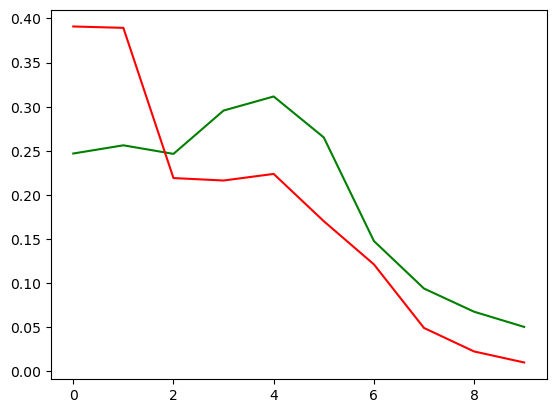

In [61]:
plt.plot(np.mean(l1,axis=0), color='green')
plt.plot(np.mean(l2,axis=0), color='red')
plt.show()

In [62]:
np.var(l1,axis=0)

array([0.0142901 , 0.00882947, 0.00842409, 0.01426126, 0.03257144,
       0.05547169, 0.00844089, 0.00375003, 0.00268882, 0.00180547])

In [63]:
np.var(l2,axis=0)

array([2.52482215e-09, 9.44308928e-09, 1.56164127e-09, 3.74218222e-09,
       3.01452163e-09, 1.25573681e-09, 4.71824180e-10, 4.72767481e-10,
       1.29980355e-11, 3.42405348e-11])

In [89]:
env.func = np.cos

env.y_init = np.cos(X)

In [99]:
l1 = []

for _ in range(10):
    state = env.Reset()
    loss1 = []
    for step in range(10):
        act = random.choices(acts,k=1)[0]
        
        state, reward, done, _ = env.Step(act)
        loss1.append(-reward)
    
        #env.toy_Plot(np.linspace(-3,3,20))
    l1.append(loss1)

In [100]:
l2 = []

for _ in range(10):
    state = env.Reset()
    loss2 = []
    for step in range(10):
        input = torch.tensor(np.concatenate(([state]*K,acts),axis=1)).float() 
        q_values = model(input)
           
        act = acts[np.argmax(q_values.detach().numpy())]
        
        state, reward, done, _ = env.Step(act)
        loss2.append(-reward)
    
        #env.toy_Plot(np.linspace(-3,3,20))
    l2.append(loss2)

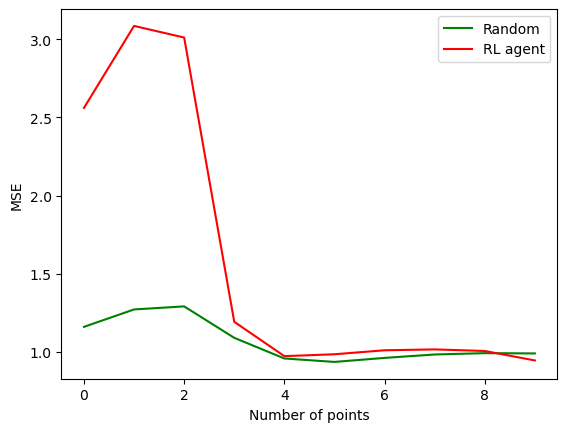

In [105]:
plt.plot(np.mean(l1,axis=0), color='green', label='Random')
plt.plot(np.mean(l2,axis=0), color='red', label='RL agent')
plt.xlabel(r"Number of points")
plt.ylabel(r"MSE")
plt.legend()
plt.show()

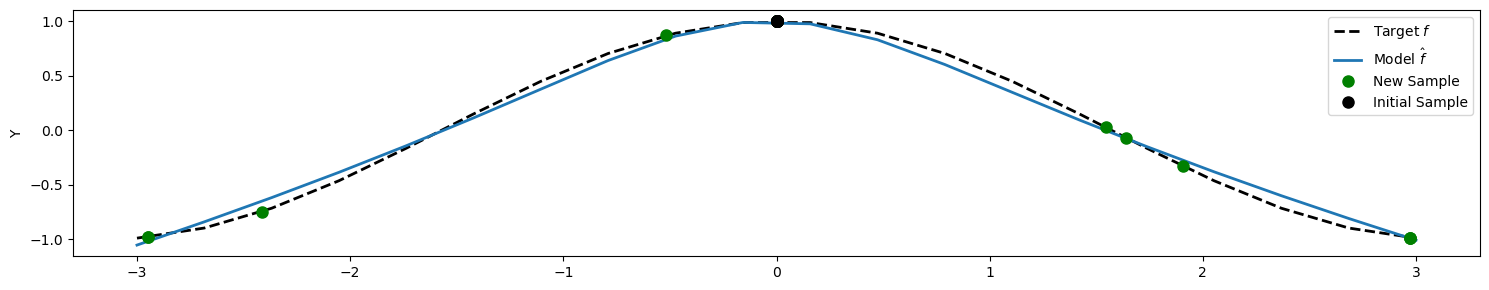

In [107]:
env.toy_Plot(np.linspace(-3,3,20))